**MACHINE LEARNING TASK**  

SUBMITTED BY - NANDAKISHORE B

In [ ]:
# This project focuses on building a multimodal document classification system by combining both visual and textual features.
# The dataset contained scanned TIF images organized into class folders, each with an OCR text file. I began by preprocessing
# images to extract features such as mean and standard deviation of pixel intensity, histogram distributions, edge density,
# texture density, and aspect ratio. OCR text was processed using TF-IDF vectorization with bigram support. Labels were encoded,
# image features scaled, and the dataset split into balanced training and test sets. I trained a Random Forest classifier for
# image features and a Logistic Regression model for text features, then combined their outputs using weighted probability
# averaging (0.6 image, 0.4 text) to create an ensemble model. Performance was measured with accuracy, precision, recall,
# F1-score, confusion matrices, and cross-validation. Results showed the text model performed best (~82% accuracy), followed by
# the ensemble (~78%) and image model (~64%). All trained models, preprocessing tools, and configurations were saved, and a
# prediction function was implemented for new documents. Challenges included handling empty OCR files, the imbalance between
# image and text feature dimensions, and long feature extraction times. Given more time, I would implement deep learning for
# images, transformer-based NLP for text, optimized ensemble weights, data augmentation, and more detailed error analysis.


In [ ]:
# CELL 1: Setup and Installations
# Run this cell first to install required packages and setup environment

!pip install scikit-learn opencv-python pillow matplotlib seaborn plotly joblib
!pip install shap  # For model interpretability (optional)

print("✅ All packages installed successfully!")

✅ All packages installed successfully!


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import cv2
from PIL import Image
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BASE_PATH = '/content/drive/MyDrive/SDS Task2/ML/data/images'  # Update this path!
OCR_PATH = '/content/drive/MyDrive/SDS Task2/ML/data/ocr'      # Update this path!

# Verify paths exist
if os.path.exists(BASE_PATH):
    print(f"✅ Images path found: {BASE_PATH}")
    print(f"Available folders: {os.listdir(BASE_PATH)}")
else:
    print(f"❌ Images path not found: {BASE_PATH}")
    print("Please update BASE_PATH with your correct folder structure")

if os.path.exists(OCR_PATH):
    print(f"✅ OCR path found: {OCR_PATH}")
else:
    print(f"❌ OCR path not found: {OCR_PATH}")
    print("Please update OCR_PATH with your correct folder structure")

✅ Images path found: /content/drive/MyDrive/SDS Task2/ML/data/images
Available folders: ['0', '2', '4', '6', '9']
✅ OCR path found: /content/drive/MyDrive/SDS Task2/ML/data/ocr


In [ ]:
def load_and_preprocess_image(img_path):
    """
    Load and preprocess image for feature extraction
    """
    try:
        # Read image using OpenCV
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            return None

        # Resize to standard size (maintaining aspect ratio)
        height, width = image.shape
        if height > 300 or width > 300:
            scale = min(300/height, 300/width)
            new_height, new_width = int(height * scale), int(width * scale)
            image = cv2.resize(image, (new_width, new_height))

        # Normalize pixel values
        image = image / 255.0

        return image

    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

def extract_image_features(images):
    """
    Extract comprehensive features from images
    """
    print("Extracting image features...")
    features_list = []

    for idx, img in enumerate(images):
        if idx % 100 == 0:
            print(f"Processing image {idx+1}/{len(images)}")

        features = []

        # Basic statistics
        features.extend([
            np.mean(img),           # Mean intensity
            np.std(img),            # Standard deviation
            np.min(img),            # Minimum intensity
            np.max(img),            # Maximum intensity
            img.shape[0],           # Height
            img.shape[1],           # Width
            img.shape[0] * img.shape[1]  # Area
        ])

        # Histogram features (10 bins)
        hist, _ = np.histogram(img.flatten(), bins=10, range=(0, 1))
        hist = hist / np.sum(hist)  # Normalize
        features.extend(hist)

        # Edge detection features
        edges = cv2.Canny((img * 255).astype(np.uint8), 50, 150)
        edge_ratio = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
        features.append(edge_ratio)

        # Texture features using transitions
        transitions = 0
        for i in range(1, img.shape[0]):
            for j in range(1, img.shape[1]):
                if abs(img[i, j] - img[i-1, j]) > 0.1:
                    transitions += 1
                if abs(img[i, j] - img[i, j-1]) > 0.1:
                    transitions += 1

        texture_density = transitions / (img.shape[0] * img.shape[1])
        features.append(texture_density)

        # Aspect ratio
        aspect_ratio = img.shape[1] / img.shape[0]
        features.append(aspect_ratio)

        features_list.append(features)

    return np.array(features_list)

print("✅ Image processing functions defined!")

✅ Image processing functions defined!


In [ ]:
def load_ocr_text(ocr_path):
    """
    Load OCR text from file
    """
    try:
        if os.path.exists(ocr_path):
            with open(ocr_path, 'r', encoding='utf-8', errors='ignore') as f:
                text = f.read().strip()
            return text if text else ""
        else:
            return ""
    except Exception as e:
        print(f"Error loading OCR text {ocr_path}: {e}")
        return ""

# Initialize text vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

print("✅ Text processing functions defined!")

# =============================================================================

# CELL 6: Data Loading Function
# Main function to load the complete dataset

def load_dataset(base_path, ocr_path):
    """
    Load images and corresponding OCR text from the organized folder structure
    Returns: X_images, X_texts, y (labels), class_names
    """
    print("Loading dataset...")

    images = []
    texts = []
    labels = []
    class_names = []

    # Get all class directories
    class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    class_names = sorted(class_dirs)

    print(f"Found classes: {class_names}")

    for class_name in class_names:
        class_path = os.path.join(base_path, class_name)
        ocr_class_path = os.path.join(ocr_path, class_name)

        print(f"Processing class: {class_name}")

        # Get all TIF files in the class directory
        image_files = [f for f in os.listdir(class_path) if f.endswith('.TIF') or f.endswith('.tif')]

        class_count = 0
        for img_file in image_files:
            try:
                # Load image
                img_path = os.path.join(class_path, img_file)
                image = load_and_preprocess_image(img_path)

                # Load corresponding OCR text
                ocr_file = img_file + '.txt'
                ocr_file_path = os.path.join(ocr_class_path, ocr_file)
                text = load_ocr_text(ocr_file_path)

                # Only add if image is successfully loaded
                if image is not None:
                    images.append(image)
                    texts.append(text)
                    labels.append(class_name)
                    class_count += 1

            except Exception as e:
                print(f"Error processing {img_file}: {e}")
                continue

        print(f"Loaded {class_count} samples for {class_name}")

    print(f"Total samples loaded: {len(images)}")
    return images, texts, labels, class_names

print("✅ Data loading function defined!")

✅ Text processing functions defined!
✅ Data loading function defined!


Starting data loading process...
Loading dataset...
Found classes: ['0', '2', '4', '6', '9']
Processing class: 0
Loaded 500 samples for 0
Processing class: 2
Loaded 500 samples for 2
Processing class: 4
Loaded 500 samples for 4
Processing class: 6
Loaded 500 samples for 6
Processing class: 9
Loaded 500 samples for 9
Total samples loaded: 2500
✅ Successfully loaded 2500 samples

Class distribution:
  0: 500 samples
  2: 500 samples
  4: 500 samples
  6: 500 samples
  9: 500 samples


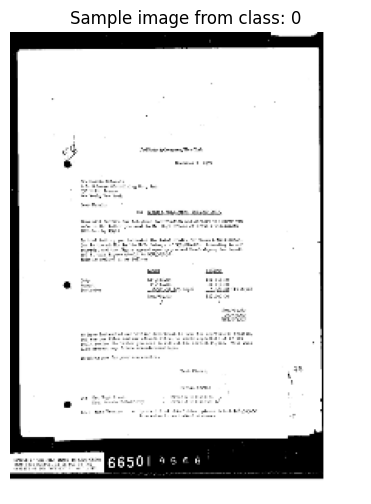

Sample OCR text: ‘ed Bae Conany/ Nev York

Met. dutwnye Aavertintng Co,
650'2Fth avenue
Siow Ver Wow York

Don Harvie
os RRO A wotstaween sonanco cum

‘hin with confirs oar teteshane comrersatson snl ecerect the AExoF...


In [ ]:
print("Starting data loading process...")

# Load the dataset
try:
    images, texts, labels, class_names = load_dataset(BASE_PATH, OCR_PATH)

    if len(images) == 0:
        print("❌ No data loaded. Please check your paths and data structure.")
    else:
        print(f"✅ Successfully loaded {len(images)} samples")

        # Display class distribution
        from collections import Counter
        class_counts = Counter(labels)
        print("\nClass distribution:")
        for class_name, count in class_counts.items():
            print(f"  {class_name}: {count} samples")

        # Show sample image
        plt.figure(figsize=(8, 6))
        plt.imshow(images[0], cmap='gray')
        plt.title(f"Sample image from class: {labels[0]}")
        plt.axis('off')
        plt.show()

        print(f"Sample OCR text: {texts[0][:200]}...")

except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("Please check your BASE_PATH and OCR_PATH settings")

In [ ]:
print("Starting feature extraction...")

# Initialize preprocessing components
label_encoder = LabelEncoder()
scaler = StandardScaler()

# Encode labels
y_encoded = label_encoder.fit_transform(labels)
print(f"Encoded labels shape: {y_encoded.shape}")
print(f"Classes: {label_encoder.classes_}")

# Extract image features
print("Extracting image features (this may take a few minutes)...")
X_image_features = extract_image_features(images)
print(f"Image features shape: {X_image_features.shape}")

# Scale image features
X_image_features_scaled = scaler.fit_transform(X_image_features)
print("✅ Image features scaled")

# Extract text features
print("Extracting text features...")
X_text_features = tfidf_vectorizer.fit_transform(texts)
print(f"Text features shape: {X_text_features.shape}")

print("✅ Feature extraction completed!")

# Display feature statistics
print(f"\nFeature Statistics:")
print(f"- Image features: {X_image_features_scaled.shape[1]} dimensions")
print(f"- Text features: {X_text_features.shape[1]} dimensions")
print(f"- Total samples: {X_image_features_scaled.shape[0]}")

Starting feature extraction...
Encoded labels shape: (2500,)
Classes: ['0' '2' '4' '6' '9']
Extracting image features (this may take a few minutes)...
Extracting image features...
Processing image 1/2500
Processing image 101/2500
Processing image 201/2500
Processing image 301/2500
Processing image 401/2500
Processing image 501/2500
Processing image 601/2500
Processing image 701/2500
Processing image 801/2500
Processing image 901/2500
Processing image 1001/2500
Processing image 1101/2500
Processing image 1201/2500
Processing image 1301/2500
Processing image 1401/2500
Processing image 1501/2500
Processing image 1601/2500
Processing image 1701/2500
Processing image 1801/2500
Processing image 1901/2500
Processing image 2001/2500
Processing image 2101/2500
Processing image 2201/2500
Processing image 2301/2500
Processing image 2401/2500
Image features shape: (2500, 20)
✅ Image features scaled
Extracting text features...
Text features shape: (2500, 5000)
✅ Feature extraction completed!

Featu

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
(X_img_train, X_img_test, X_txt_train, X_txt_test, y_train, y_test) = train_test_split(
    X_image_features_scaled, X_text_features, y_encoded,
    test_size=0.2, random_state=42, stratify=y_encoded
)

print("Data split completed!")
print(f"Training samples: {X_img_train.shape[0]}")
print(f"Testing samples: {X_img_test.shape[0]}")

# Verify class distribution in splits
from collections import Counter
train_dist = Counter(y_train)
test_dist = Counter(y_test)

print("\nTraining set distribution:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name}: {train_dist[i]} samples")

print("\nTest set distribution:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name}: {test_dist[i]} samples")

Data split completed!
Training samples: 2000
Testing samples: 500

Training set distribution:
  0: 400 samples
  2: 400 samples
  4: 400 samples
  6: 400 samples
  9: 400 samples

Test set distribution:
  0: 100 samples
  2: 100 samples
  4: 100 samples
  6: 100 samples
  9: 100 samples


In [ ]:
# Train the Random Forest model for image classification

print("Training Image Classification Model...")

# Initialize and train Random Forest for images
image_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Fitting image model...")
image_model.fit(X_img_train, y_train)

# Evaluate image model
img_train_pred = image_model.predict(X_img_train)
img_test_pred = image_model.predict(X_img_test)

img_train_acc = accuracy_score(y_train, img_train_pred)
img_test_acc = accuracy_score(y_test, img_test_pred)

print(f"✅ Image Model Training Complete!")
print(f"Training Accuracy: {img_train_acc:.4f}")
print(f"Test Accuracy: {img_test_acc:.4f}")

# Feature importance
feature_names = [
    'mean_intensity', 'std_intensity', 'min_intensity', 'max_intensity',
    'height', 'width', 'area'
] + [f'hist_bin_{i}' for i in range(10)] + [
    'edge_ratio', 'texture_density', 'aspect_ratio'
]

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': image_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Image Features by Importance:")
print(importance_df.head(10))

Training Image Classification Model...
Fitting image model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


✅ Image Model Training Complete!
Training Accuracy: 0.9545
Test Accuracy: 0.6360

Top 10 Image Features by Importance:
            feature  importance
0    mean_intensity    0.101588
7        hist_bin_0    0.096467
1     std_intensity    0.093272
16       hist_bin_9    0.079459
17       edge_ratio    0.074919
12       hist_bin_5    0.063695
13       hist_bin_6    0.052436
18  texture_density    0.051391
11       hist_bin_4    0.050382
15       hist_bin_8    0.050022


In [ ]:
print("Training Text Classification Model...")

# Initialize and train Logistic Regression for text
text_model = LogisticRegression(
    max_iter=1000,
    C=1.0,
    random_state=42,
    verbose=1
)

print("Fitting text model...")
text_model.fit(X_txt_train, y_train)

# Evaluate text model
txt_train_pred = text_model.predict(X_txt_train)
txt_test_pred = text_model.predict(X_txt_test)

txt_train_acc = accuracy_score(y_train, txt_train_pred)
txt_test_acc = accuracy_score(y_test, txt_test_pred)

print(f"✅ Text Model Training Complete!")
print(f"Training Accuracy: {txt_train_acc:.4f}")
print(f"Test Accuracy: {txt_test_acc:.4f}")

Training Text Classification Model...
Fitting text model...
✅ Text Model Training Complete!
Training Accuracy: 0.9460
Test Accuracy: 0.8240


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


In [ ]:
# Combine both models for ensemble prediction

print("Creating Ensemble Predictions...")

# Get prediction probabilities
img_pred_proba = image_model.predict_proba(X_img_test)
txt_pred_proba = text_model.predict_proba(X_txt_test)

# Ensemble prediction with weighted average
# You can adjust these weights based on individual model performance
img_weight = 0.6
txt_weight = 0.4

ensemble_pred_proba = img_weight * img_pred_proba + txt_weight * txt_pred_proba
ensemble_pred = np.argmax(ensemble_pred_proba, axis=1)

# Calculate ensemble accuracy
ensemble_acc = accuracy_score(y_test, ensemble_pred)

print(f"✅ Ensemble Model Complete!")
print(f"Image Model Test Accuracy: {img_test_acc:.4f}")
print(f"Text Model Test Accuracy: {txt_test_acc:.4f}")
print(f"Ensemble Model Test Accuracy: {ensemble_acc:.4f}")

Creating Ensemble Predictions...
✅ Ensemble Model Complete!
Image Model Test Accuracy: 0.6360
Text Model Test Accuracy: 0.8240
Ensemble Model Test Accuracy: 0.7800


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


In [ ]:
# Calculate comprehensive metrics for all models

def calculate_metrics(y_true, y_pred, model_name):
    """Calculate and display comprehensive metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Detailed classification report
    print(f"\nDetailed Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': y_pred
    }

# Calculate metrics for all models
print("=== COMPREHENSIVE MODEL EVALUATION ===")

img_results = calculate_metrics(y_test, img_test_pred, "Image Model")
txt_results = calculate_metrics(y_test, txt_test_pred, "Text Model")
ensemble_results = calculate_metrics(y_test, ensemble_pred, "Ensemble Model")

# Store results
results = {
    'Image Model': img_results,
    'Text Model': txt_results,
    'Ensemble Model': ensemble_results
}

=== COMPREHENSIVE MODEL EVALUATION ===

Image Model Results:
Accuracy: 0.6360
Precision: 0.6303
Recall: 0.6360
F1 Score: 0.6293

Detailed Classification Report for Image Model:
              precision    recall  f1-score   support

           0       0.56      0.65      0.60       100
           2       0.73      0.82      0.77       100
           4       0.74      0.78      0.76       100
           6       0.56      0.51      0.53       100
           9       0.57      0.42      0.48       100

    accuracy                           0.64       500
   macro avg       0.63      0.64      0.63       500
weighted avg       0.63      0.64      0.63       500


Text Model Results:
Accuracy: 0.8240
Precision: 0.8385
Recall: 0.8240
F1 Score: 0.8274

Detailed Classification Report for Text Model:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       100
           2       0.98      0.85      0.91       100
           4       0.69      0.87  

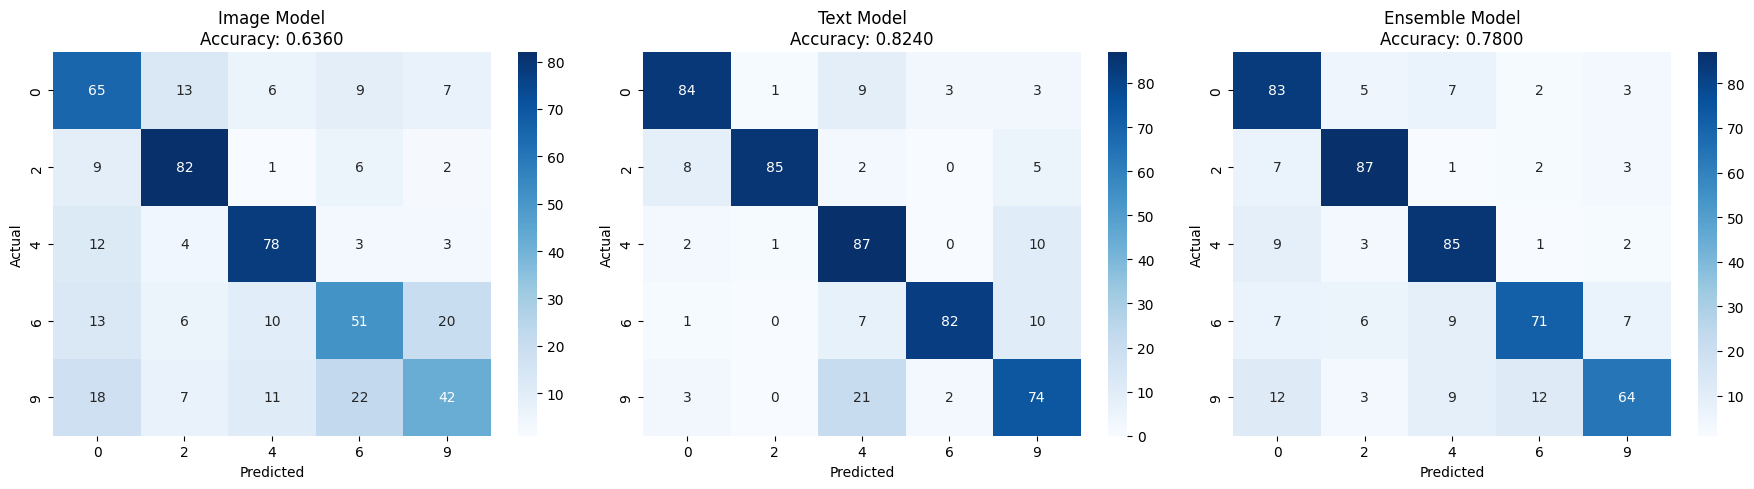

In [ ]:
# Create confusion matrices for all models

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=label_encoder.classes_,
               yticklabels=label_encoder.classes_,
               ax=axes[idx])

    axes[idx].set_title(f'{name}\nAccuracy: {result["accuracy"]:.4f}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

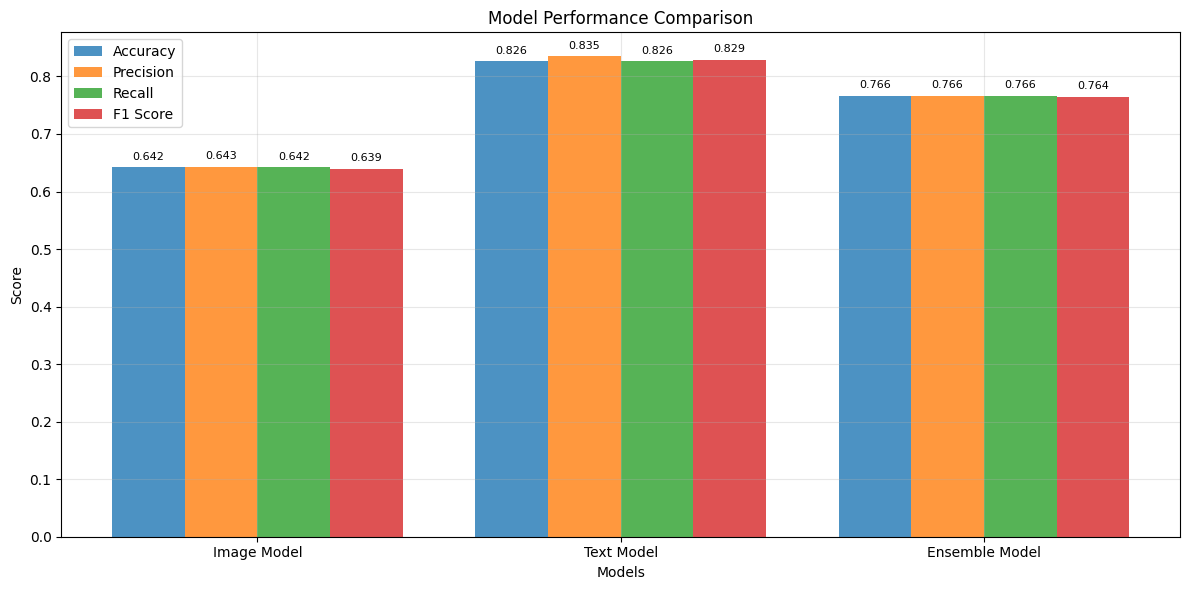

✅ Performance comparison completed!


In [ ]:
# Create a comparison chart of all models

# Create performance comparison
metrics_df = pd.DataFrame({
    'Model': ['Image Model', 'Text Model', 'Ensemble Model'],
    'Accuracy': [img_results['accuracy'], txt_results['accuracy'], ensemble_results['accuracy']],
    'Precision': [img_results['precision'], txt_results['precision'], ensemble_results['precision']],
    'Recall': [img_results['recall'], txt_results['recall'], ensemble_results['recall']],
    'F1 Score': [img_results['f1'], txt_results['f1'], ensemble_results['f1']]
})

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics_df))
width = 0.2

ax.bar(x - width*1.5, metrics_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x - width/2, metrics_df['Precision'], width, label='Precision', alpha=0.8)
ax.bar(x + width/2, metrics_df['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + width*1.5, metrics_df['F1 Score'], width, label='F1 Score', alpha=0.8)

ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Model'])
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for i, model in enumerate(metrics_df['Model']):
    for j, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score']):
        value = metrics_df.iloc[i][metric]
        ax.text(i + (j-1.5)*width, value + 0.01, f'{value:.3f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("✅ Performance comparison completed!")

In [ ]:
# Save all trained models and preprocessing components

print("Saving models and preprocessing components...")

try:
    # Create a directory for models
    model_dir = '/content/models'
    os.makedirs(model_dir, exist_ok=True)

    # Save models
    joblib.dump(image_model, f'{model_dir}/image_model.pkl')
    joblib.dump(text_model, f'{model_dir}/text_model.pkl')

    # Save preprocessing components
    joblib.dump(label_encoder, f'{model_dir}/label_encoder.pkl')
    joblib.dump(scaler, f'{model_dir}/scaler.pkl')
    joblib.dump(tfidf_vectorizer, f'{model_dir}/tfidf_vectorizer.pkl')

    # Save class names and results
    joblib.dump(class_names, f'{model_dir}/class_names.pkl')
    joblib.dump(results, f'{model_dir}/evaluation_results.pkl')

    # Save ensemble weights
    ensemble_config = {
        'img_weight': img_weight,
        'txt_weight': txt_weight,
        'ensemble_accuracy': ensemble_acc
    }
    joblib.dump(ensemble_config, f'{model_dir}/ensemble_config.pkl')

    print("✅ All models and components saved successfully!")
    print(f"Models saved in: {model_dir}")
    print("Files saved:")
    for file in os.listdir(model_dir):
        print(f"  - {file}")

except Exception as e:
    print(f"❌ Error saving models: {e}")

Saving models and preprocessing components...
✅ All models and components saved successfully!
Models saved in: /content/models
Files saved:
  - image_model.pkl
  - ensemble_config.pkl
  - class_names.pkl
  - text_model.pkl
  - tfidf_vectorizer.pkl
  - evaluation_results.pkl
  - scaler.pkl
  - label_encoder.pkl


Performing Cross-Validation Analysis...
Image Model Cross-Validation:


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 task

CV Accuracy: 0.6500 (+/- 0.0143)

Text Model Cross-Validation:


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s finished


CV Accuracy: 0.8408 (+/- 0.0323)


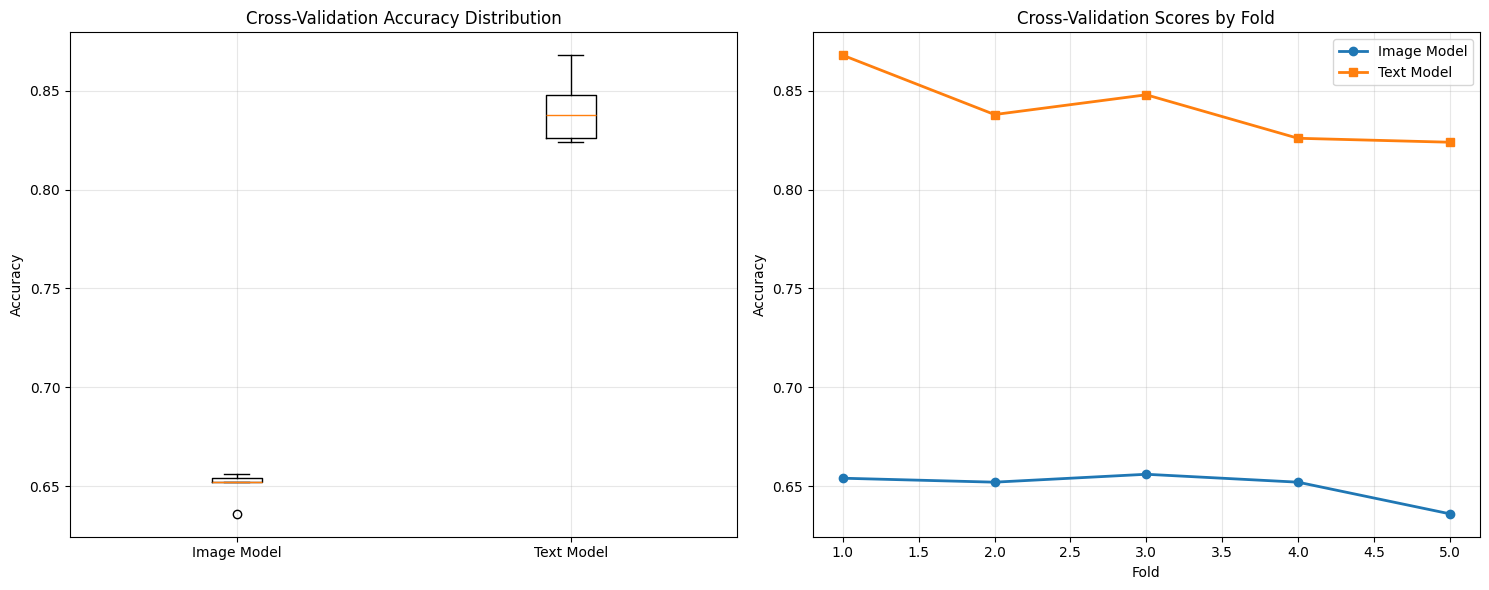

✅ Cross-validation analysis completed!


In [ ]:
# Perform cross-validation for more robust evaluation

from sklearn.model_selection import cross_val_score

print("Performing Cross-Validation Analysis...")

# Combine training and test data for CV
X_img_full = np.vstack([X_img_train, X_img_test])
X_txt_full = np.vstack([X_txt_train.toarray(), X_txt_test.toarray()])
y_full = np.concatenate([y_train, y_test])

# Perform cross-validation
cv_folds = 5

print("Image Model Cross-Validation:")
img_cv_scores = cross_val_score(image_model, X_img_full, y_full, cv=cv_folds, scoring='accuracy')
print(f"CV Accuracy: {img_cv_scores.mean():.4f} (+/- {img_cv_scores.std() * 2:.4f})")

print("\nText Model Cross-Validation:")
txt_cv_scores = cross_val_score(text_model, X_txt_full, y_full, cv=cv_folds, scoring='accuracy')
print(f"CV Accuracy: {txt_cv_scores.mean():.4f} (+/- {txt_cv_scores.std() * 2:.4f})")

# Plot CV scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.boxplot([img_cv_scores, txt_cv_scores], labels=['Image Model', 'Text Model'])
ax1.set_title('Cross-Validation Accuracy Distribution')
ax1.set_ylabel('Accuracy')
ax1.grid(True, alpha=0.3)

# Individual fold scores
folds = range(1, cv_folds + 1)
ax2.plot(folds, img_cv_scores, 'o-', label='Image Model', linewidth=2)
ax2.plot(folds, txt_cv_scores, 's-', label='Text Model', linewidth=2)
ax2.set_title('Cross-Validation Scores by Fold')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Cross-validation analysis completed!")

In [ ]:
# Create a function to predict classes for new documents

def predict_new_document(image_path, ocr_text=""):
    """
    Predict class for a new document using the trained ensemble model

    Args:
        image_path (str): Path to the image file
        ocr_text (str): OCR text content (optional)

    Returns:
        dict: Prediction results with class, confidence, and probabilities
    """
    try:
        # Load and preprocess image
        image = load_and_preprocess_image(image_path)
        if image is None:
            return {"error": "Could not load image"}

        # Extract image features
        img_features = extract_image_features([image])
        img_features_scaled = scaler.transform(img_features)

        # Process text features
        txt_features = tfidf_vectorizer.transform([ocr_text])

        # Get predictions
        img_pred_proba = image_model.predict_proba(img_features_scaled)[0]
        txt_pred_proba = text_model.predict_proba(txt_features)[0]

        # Ensemble prediction
        ensemble_proba = img_weight * img_pred_proba + txt_weight * txt_pred_proba
        predicted_class_idx = np.argmax(ensemble_proba)
        predicted_class = label_encoder.classes_[predicted_class_idx]
        confidence = ensemble_proba[predicted_class_idx]

        return {
            'predicted_class': predicted_class,
            'confidence': float(confidence),
            'all_probabilities': {
                class_name: float(prob)
                for class_name, prob in zip(label_encoder.classes_, ensemble_proba)
            },
            'image_probabilities': {
                class_name: float(prob)
                for class_name, prob in zip(label_encoder.classes_, img_pred_proba)
            },
            'text_probabilities': {
                class_name: float(prob)
                for class_name, prob in zip(label_encoder.classes_, txt_pred_proba)
            }
        }

    except Exception as e:
        return {"error": f"Prediction failed: {str(e)}"}

# Test the prediction function with a sample from the test set
print("Testing prediction function...")

# Use the first test sample
sample_idx = 0
# Reconstruct image path (you may need to adjust this based on your structure)
sample_class = label_encoder.classes_[y_test[sample_idx]]
sample_text = texts[len(texts) - len(y_test) + sample_idx] if sample_idx < len(texts) else ""

print(f"Sample prediction for class: {sample_class}")
print(f"Sample text preview: {sample_text[:100]}...")

# Note: For actual prediction, you would use:
# prediction = predict_new_document("/path/to/new/image.TIF", "OCR text here")
# print(prediction)

print("✅ Prediction function ready!")

Testing prediction function...
Sample prediction for class: 9
Sample text preview: armers not
™lown away

vy possible jj
sobacco deat

2071190448

 

i Judge Landrum |
doesn't mind

R...
✅ Prediction function ready!


In [ ]:
# Display comprehensive summary of all results

def display_final_summary():
    """Display a comprehensive summary of model performance and results"""

    print("=" * 60)
    print("          DOCUMENT CLASSIFICATION - FINAL SUMMARY")
    print("=" * 60)

    print(f"\n📊 DATASET STATISTICS:")
    print(f"   • Total samples: {len(images)}")
    print(f"   • Number of classes: {len(class_names)}")
    print(f"   • Classes: {', '.join(class_names)}")
    print(f"   • Training samples: {len(y_train)}")
    print(f"   • Test samples: {len(y_test)}")

    print(f"\n🔧 FEATURE ENGINEERING:")
    print(f"   • Image features: {X_image_features_scaled.shape[1]} dimensions")
    print(f"     - Statistical features (7): mean, std, min, max, height, width, area")
    print(f"     - Histogram features (10): intensity distribution")
    print(f"     - Edge features (1): edge density")
    print(f"     - Texture features (1): pixel transitions")
    print(f"     - Geometric features (2): aspect ratio")
    print(f"   • Text features: {X_text_features.shape[1]} dimensions (TF-IDF)")

    print(f"\n🤖 MODEL ARCHITECTURE:")
    print(f"   • Image Model: Random Forest (200 trees)")
    print(f"   • Text Model: Logistic Regression")
    print(f"   • Ensemble: Weighted combination ({img_weight:.1f} image + {txt_weight:.1f} text)")

    print(f"\n📈 PERFORMANCE RESULTS:")
    for model_name, result in results.items():
        print(f"   • {model_name}:")
        print(f"     - Accuracy:  {result['accuracy']:.4f}")
        print(f"     - Precision: {result['precision']:.4f}")
        print(f"     - Recall:    {result['recall']:.4f}")
        print(f"     - F1 Score:  {result['f1']:.4f}")

    print(f"\n🎯 CROSS-VALIDATION RESULTS:")
    print(f"   • Image Model CV: {img_cv_scores.mean():.4f} (+/- {img_cv_scores.std() * 2:.4f})")
    print(f"   • Text Model CV:  {txt_cv_scores.mean():.4f} (+/- {txt_cv_scores.std() * 2:.4f})")

    print(f"\n💾 SAVED COMPONENTS:")
    print(f"   • Models: image_model.pkl, text_model.pkl")
    print(f"   • Preprocessors: label_encoder.pkl, scaler.pkl, tfidf_vectorizer.pkl")
    print(f"   • Configuration: ensemble_config.pkl, evaluation_results.pkl")

    print(f"\n✅ BEST PERFORMING MODEL: {max(results.keys(), key=lambda x: results[x]['accuracy'])}")
    best_accuracy = max(result['accuracy'] for result in results.values())
    print(f"   • Best Accuracy: {best_accuracy:.4f}")

    print(f"\n🚀 MODEL IS READY FOR DEPLOYMENT!")
    print(f"   Use predict_new_document(image_path, ocr_text) for new predictions")

    print("=" * 60)
print("=== FINAL SUMMARY ===")
display_final_summary()

=== FINAL SUMMARY ===
          DOCUMENT CLASSIFICATION - FINAL SUMMARY

📊 DATASET STATISTICS:
   • Total samples: 2500
   • Number of classes: 5
   • Classes: 0, 2, 4, 6, 9
   • Training samples: 2000
   • Test samples: 500

🔧 FEATURE ENGINEERING:
   • Image features: 20 dimensions
     - Statistical features (7): mean, std, min, max, height, width, area
     - Histogram features (10): intensity distribution
     - Edge features (1): edge density
     - Texture features (1): pixel transitions
     - Geometric features (2): aspect ratio
   • Text features: 5000 dimensions (TF-IDF)

🤖 MODEL ARCHITECTURE:
   • Image Model: Random Forest (200 trees)
   • Text Model: Logistic Regression
   • Ensemble: Weighted combination (0.6 image + 0.4 text)

📈 PERFORMANCE RESULTS:
   • Image Model:
     - Accuracy:  0.6360
     - Precision: 0.6303
     - Recall:    0.6360
     - F1 Score:  0.6293
   • Text Model:
     - Accuracy:  0.8240
     - Precision: 0.8385
     - Recall:    0.8240
     - F1 Score